In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, ConvLSTM2D, Conv3D, BatchNormalization, Lambda, Reshape
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import data_preprocessing as dpp
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.random.set_seed(1)
np.random.seed(1)

# Data Preprocessing

In [2]:
img_folder = 'data/data1-(8.7μm)'

img_tensors = dpp.preprocess_images(img_folder,target_size=(50,50), end_i=40)

print(img_tensors)

[[[[0.42745098 0.42745098 0.42745098 1.        ]
   [0.42745098 0.42745098 0.42745098 1.        ]
   [0.42352941 0.42352941 0.42352941 1.        ]
   ...
   [0.45490196 0.45490196 0.45490196 1.        ]
   [0.44705882 0.44705882 0.44705882 1.        ]
   [0.45490196 0.45490196 0.45490196 1.        ]]

  [[0.42745098 0.42745098 0.42745098 1.        ]
   [0.41960784 0.41960784 0.41960784 1.        ]
   [0.42745098 0.42745098 0.42745098 1.        ]
   ...
   [0.44705882 0.44705882 0.44705882 1.        ]
   [0.45882353 0.45882353 0.45882353 1.        ]
   [0.45882353 0.45882353 0.45882353 1.        ]]

  [[0.41568627 0.41568627 0.41568627 1.        ]
   [0.41568627 0.41568627 0.41568627 1.        ]
   [0.42352941 0.42352941 0.42352941 1.        ]
   ...
   [0.44705882 0.44705882 0.44705882 1.        ]
   [0.45882353 0.45882353 0.45882353 1.        ]
   [0.45882353 0.45882353 0.45882353 1.        ]]

  ...

  [[1.         1.         0.         1.        ]
   [0.34117647 0.34117647 0.3411764

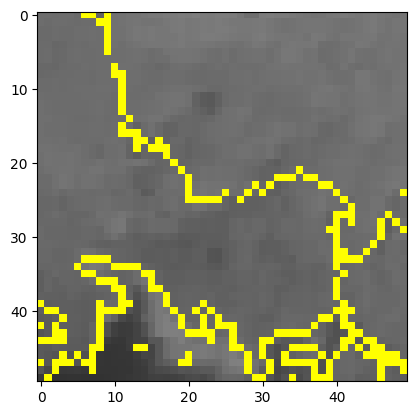

In [3]:
plt.imshow(img_tensors[0])

In [7]:
data_2410_300 = np.load("data/data_/data_2410_300.npy")
data_2410_715 = np.load("data/data_/data_2410_715.npy")
print(data_2410_300.shape, data_2410_715.shape )
data_2410 = np.concatenate((data_2410_300, data_2410_715), axis=0)
print(data_2410.shape)
inputs, outputs = dpp.split_images(data_2410)
print(inputs.shape, outputs.shape)
"""inputs = np.load("data/data_/data_2410_input.npy")
outputs = np.load("data/data_/data_2410_output.npy")"""

(300, 40, 40, 4) (415, 40, 40, 4)
(715, 40, 40, 4)
(47, 14, 40, 40, 4) (47, 1, 40, 40, 4)


'inputs = np.load("data/data_/data_2410_input.npy")\noutputs = np.load("data/data_/data_2410_output.npy")'

In [11]:
#기존 데이터 크기인 47,15,850,850,4를 하면 2,037,450,000개의 공간이 생김 (20억개???)
#기존 연구 28,30,40,1 -> 33,600개
#rgba 4개의 채널까지 하더라도 134,400개임
#100,15,40,40,4 -> 최대 천만개
inputs.shape, outputs.shape
np.save("data/data_/data_2410_input",inputs)
np.save("data/data_/data_2410_output",outputs)

In [2]:
inputs = np.load("data/data_/data_2410_input.npy")
outputs = np.load("data/data_/data_2410_output.npy")

In [4]:
data_2410 = np.load("data/data_/data_2410.npy")

In [15]:
data_2410.shape

(715, 850, 850, 4)

In [20]:
def resize_images(dataset, target_size):
    resized_dataset = tf.image.resize(dataset, target_size, method='bilinear')
    return resized_dataset
resized_images = resize_images(data_2410[300:], (40,40))

In [21]:
np.save("data/data_/data_2410_715", resized_images)

# Modeling

In [14]:
# 자 모델 구축 들갑니다~
model = Sequential()
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     input_shape=(None,40,40,4), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=False))
model.add(Reshape((1, 40, 40, 40)))
model.add(BatchNormalization())
model.add(Conv3D(filters=4, 
                 kernel_size=(3,3,3), 
                 activation="sigmoid",
                 padding="same"))
optimizer = Adadelta(learning_rate=2.0)
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics = ['accuracy'])
callbacks_val_acc = [EarlyStopping(monitor='val_accuracy', patience=7, mode='max', restore_best_weights=True),
                     ModelCheckpoint("ClimateAI.keras", monitor='val_accuracy', save_best_only=True)]
callbacks_val_loss = [EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True),
                      ModelCheckpoint("ClimateAI.keras", monitor='val_loss', save_best_only=True)]
callbacks = [callbacks_val_acc, callbacks_val_loss]

model.summary()

/Volumes/looparam/#1 Coding/#10 Python/AcademicFestival/AF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, None, 40, 40,   │        63,520 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)     │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, 40, 40, 40)     │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 40, 40, 40)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 40, 40, 40)  │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 1, 40, 40, 4)   │         4,324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,564 (1.58 MB)

 Trainable params: 414,244 (1.58 MB)

 Non-trainable params: 320 (1.25 KB)

# Train

In [15]:
model.fit(inputs, outputs, epochs=10, batch_size=1, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.5167 - loss: 0.6117 - val_accuracy: 0.9972 - val_loss: 0.5503
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.9851 - loss: 0.4288 - val_accuracy: 0.9972 - val_loss: 0.5216
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.9970 - loss: 0.4064 - val_accuracy: 0.9972 - val_loss: 0.5136
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.9970 - loss: 0.3987 - val_accuracy: 0.9972 - val_loss: 0.5072
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.9970 - loss: 0.3946 - val_accuracy: 0.9972 - val_loss: 0.4971
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.9970 - loss: 0.3910 - val_accuracy: 0.9972 - val_loss: 0.4909
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.9970 - loss: 0.3895 - val_accuracy: 0.9972 - val_loss: 0.4820
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.9970 - loss: 0.3884 - val_accu

In [16]:
loded_model = tf.keras.models.load_model("./ClimateAI.keras")

In [17]:
test = loded_model.predict(inputs)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [26]:
test.shape, inputs.shape

((47, 1, 40, 40, 4), (47, 14, 40, 40, 4))

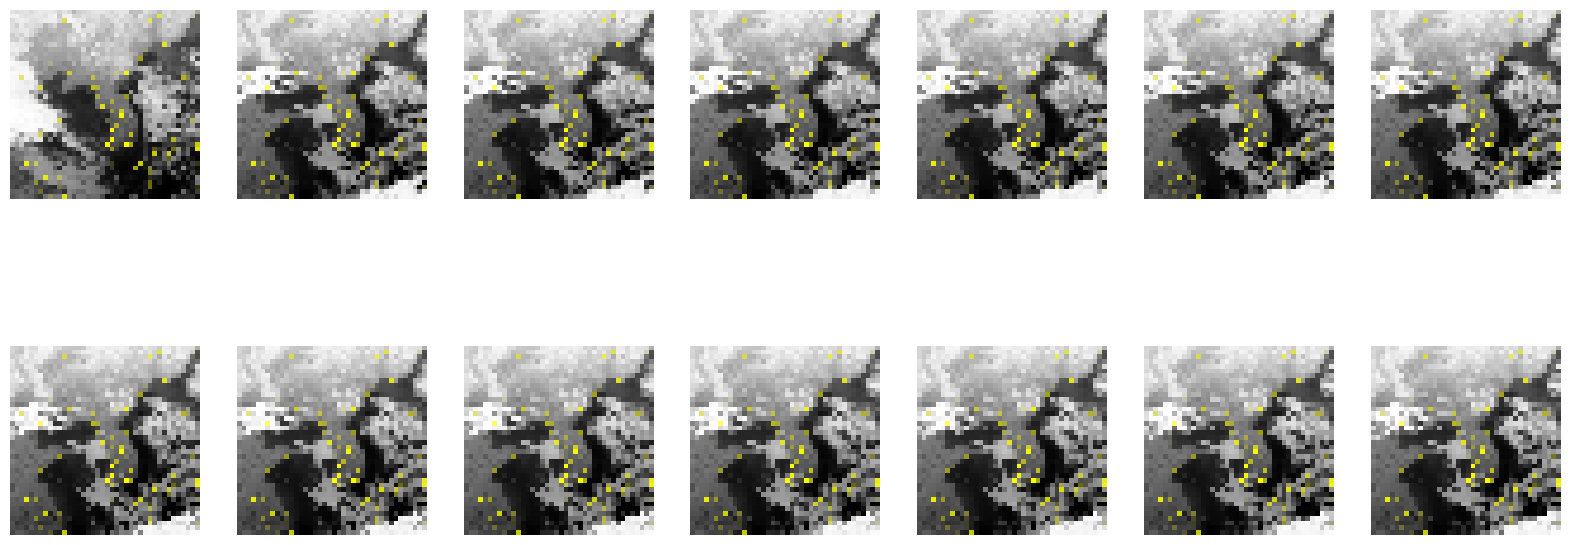

In [30]:
plt.figure(figsize=(20, 8))

for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(inputs[0, i, :, :, :])  # 필요한 축만 선택해서 시각화
    plt.axis('off')
plt.show()

In [50]:
test[0][0][0][0][:]

array([0.4958, 0.589 , 0.6064, 0.488 ], dtype=float16)

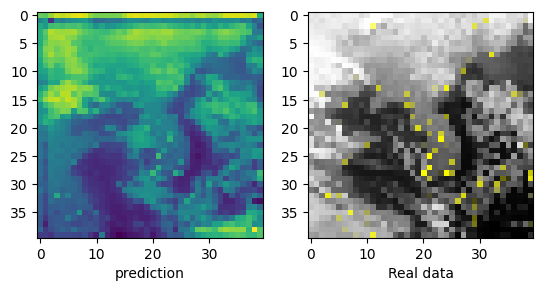

In [38]:
test = test.astype('float32')
plt.subplot(1, 2, 1)
plt.imshow(test[0, 0, :, :, 1])  # 필요한 축만 선택해서 시각화
plt.xlabel("prediction")
plt.subplot(1,2,2)
plt.imshow(outputs[0,0,:,:,:])
plt.xlabel("Real data")
plt.show()

In [58]:
inputs.dtype, test.dtype

(dtype('float32'), dtype('float16'))